<a href="https://colab.research.google.com/github/jamessat/neural-networks-demo/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import keras

# Load the MNIST dataset using Keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Flatten the images
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Normalize the pixel values
x_train_norm = x_train_flat.astype('float32') / 255.0
x_test_norm = x_test_flat.astype('float32') / 255.0

# We will keep the labels as integers for now, one-hot encoding will be handled later
y_train_int = y_train
y_test_int = y_test


print("Original shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

print("\nProcessed shapes:")
print("x_train_norm:", x_train_norm.shape)
print("y_train_int:", y_train_int.shape)
print("x_test_norm:", x_test_norm.shape)
print("y_test_int:", y_test_int.shape)

Original shapes:
x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)

Processed shapes:
x_train_norm: (60000, 784)
y_train_int: (60000,)
x_test_norm: (10000, 784)
y_test_int: (10000,)


In [3]:
# Define the number of input, hidden, and output units
input_size = x_train_norm.shape[1] # 28 * 28 = 784
hidden_size = 128 # This is a hyperparameter you can tune
output_size = 10 # 10 digits (0-9)

# Initialize weights and biases
# Weights are initialized with small random values (using a normal distribution)
# Biases are initialized with zeros

# Weights for input to hidden layer
W1 = np.random.randn(input_size, hidden_size) * 0.01
# Biases for hidden layer
b1 = np.zeros((1, hidden_size))

# Weights for hidden to output layer
W2 = np.random.randn(hidden_size, output_size) * 0.01
# Biases for output layer
b2 = np.zeros((1, output_size))

print("Shapes of initialized parameters:")
print("W1:", W1.shape)
print("b1:", b1.shape)
print("W2:", W2.shape)
print("b2:", b2.shape)

Shapes of initialized parameters:
W1: (784, 128)
b1: (1, 128)
W2: (128, 10)
b2: (1, 10)


In [4]:
def relu(Z):
    """
    Implement the ReLU activation function.

    Arguments:
    Z -- numpy array of any shape

    Returns:
    A -- Output of relu(Z), same shape as Z
    """
    A = np.maximum(0, Z)
    return A

def softmax(Z):
    """
    Implement the Softmax activation function.

    Arguments:
    Z -- numpy array of shape (1, number of output units) or (number of examples, number of output units)

    Returns:
    A -- Output of softmax(Z), same shape as Z
    """
    # Subtract the maximum value for numerical stability
    exp_scores = np.exp(Z - np.max(Z, axis=-1, keepdims=True))
    A = exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)
    return A

# We'll also need the derivatives for backpropagation

def relu_backward(dA, Z):
    """
    Implement the backward propagation for a single ReLU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    Z -- input of the activation function (used to compute the gradient)

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    dZ = np.array(dA, copy=True) # just converting dA to a numpy array
    # When Z <= 0, set dZ to 0
    dZ[Z <= 0] = 0
    return dZ

# Note: The derivative of the softmax function combined with the cross-entropy loss
# is simply (A - Y), where A is the output probabilities and Y is the true labels (one-hot encoded).
# We will handle this directly in the backward propagation step for the output layer.

In [5]:
def forward_propagation(X, W1, b1, W2, b2):
    """
    Implement forward propagation for the two-layer neural network.

    Arguments:
    X -- input data (number of examples, input size)
    W1 -- weights for the hidden layer (input size, hidden size)
    b1 -- biases for the hidden layer (1, hidden size)
    W2 -- weights for the output layer (hidden size, output size)
    b2 -- biases for the output layer (1, output size)

    Returns:
    A2 -- the output of the softmax activation, also known as the post-activation value of the second layer
    cache -- a dictionary containing "Z1", "A1", "Z2" needed for the backward pass
    """
    # Layer 1: Linear -> ReLU
    Z1 = X @ W1 + b1
    A1 = relu(Z1)

    # Layer 2: Linear -> Softmax
    Z2 = A1 @ W2 + b2
    A2 = softmax(Z2)

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    return A2, cache

In [6]:
def one_hot_encode(Y, num_classes):
    """
    Converts a vector of labels into a one-hot encoded matrix.

    Arguments:
    Y -- numpy array of labels (shape: (number of examples,))
    num_classes -- the total number of unique classes (e.g., 10 for MNIST digits)

    Returns:
    one_hot_Y -- one-hot encoded matrix (shape: (number of examples, num_classes))
    """
    one_hot_Y = np.zeros((Y.size, num_classes))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y

def compute_loss(A2, Y):
    """
    Computes the cross-entropy loss.

    Arguments:
    A2 -- The output of the softmax activation (shape: (number of examples, num_classes))
    Y -- The true labels, one-hot encoded (shape: (number of examples, num_classes))

    Returns:
    loss -- The cross-entropy loss
    """
    m = Y.shape[0] # Number of examples
    # Avoid log(0) by clipping probabilities
    epsilon = 1e-12
    A2 = np.clip(A2, epsilon, 1. - epsilon)
    loss = -np.sum(Y * np.log(A2)) / m
    return loss

# Convert training and test labels to one-hot encoding
num_classes = output_size # Already defined as 10
y_train_one_hot = one_hot_encode(y_train_int, num_classes)
y_test_one_hot = one_hot_encode(y_test_int, num_classes)

print("Shape of one-hot encoded training labels:", y_train_one_hot.shape)
print("Shape of one-hot encoded test labels:", y_test_one_hot.shape)

Shape of one-hot encoded training labels: (60000, 10)
Shape of one-hot encoded test labels: (10000, 10)


In [7]:
def backward_propagation(X, Y, cache, W2):
    """
    Implement the backward propagation for the two-layer neural network.

    Arguments:
    X -- input data (number of examples, input size)
    Y -- true labels, one-hot encoded (number of examples, output size)
    cache -- dictionary containing "Z1", "A1", "Z2", "A2" from the forward pass
    W2 -- weights of the output layer (hidden size, output size)

    Returns:
    grads -- a dictionary with the gradients with respect to W1, b1, W2, and b2
    """
    m = X.shape[0] # Number of examples

    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    Z2 = cache["Z2"]

    # Backward pass for the output layer (Linear -> Softmax)
    # The derivative of the loss with respect to Z2 is A2 - Y for cross-entropy loss with Softmax
    dZ2 = A2 - Y

    # Gradients for W2 and b2
    dW2 = (A1.T @ dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Backward pass for the hidden layer (Linear -> ReLU)
    # Gradient of loss with respect to A1
    dA1 = dZ2 @ W2.T

    # Gradient of loss with respect to Z1 (using ReLU backward)
    dZ1 = relu_backward(dA1, Z1)

    # Gradients for W1 and b1
    dW1 = (X.T @ dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [8]:
def update_parameters(W1, b1, W2, b2, grads, learning_rate):
    """
    Updates parameters using the gradient descent update rule.

    Arguments:
    W1 -- weights matrix of shape (input_size, hidden_size)
    b1 -- bias vector of shape (1, hidden_size)
    W2 -- weights matrix of shape (hidden_size, output_size)
    b2 -- bias vector of shape (1, output_size)
    grads -- python dictionary containing gradients with respect to weights and biases
    learning_rate -- the learning rate for the update rule

    Returns:
    parameters -- python dictionary containing the updated parameters
    """
    # Retrieve gradients from grads dictionary
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]

    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

In [10]:
def train_model(X_train, Y_train, input_size, hidden_size, output_size, num_epochs, learning_rate):
    """
    Trains the two-layer neural network using gradient descent.

    Arguments:
    X_train -- training data (number of training examples, input size)
    Y_train -- true training labels, one-hot encoded (number of training examples, output size)
    input_size -- size of the input layer
    hidden_size -- size of the hidden layer
    output_size -- size of the output layer
    num_epochs -- number of iterations over the training set
    learning_rate -- the learning rate for parameter updates

    Returns:
    parameters -- python dictionary containing the learned parameters (W1, b1, W2, b2)
    losses -- list of loss values recorded during training
    """
    # Initialize parameters
    W1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros((1, output_size))

    losses = []

    # Training loop
    for i in range(num_epochs):

        # Forward propagation
        A2, cache = forward_propagation(X_train, W1, b1, W2, b2)

        # Compute loss
        loss = compute_loss(A2, Y_train)
        losses.append(loss)

        # Backward propagation
        grads = backward_propagation(X_train, Y_train, cache, W2)

        # Update parameters
        parameters = update_parameters(W1, b1, W2, b2, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]


        # Print loss every 100 epochs
        if i % 100 == 0:
            print(f"Loss after epoch {i}: {loss}")

    return parameters, losses

# Define hyperparameters for training
num_epochs = 1000
learning_rate = 0.1

# Train the model
# We use the normalized training data and one-hot encoded training labels
parameters, training_losses = train_model(x_train_norm, y_train_one_hot, input_size, hidden_size, output_size, num_epochs, learning_rate)

print("\nTraining finished.")

Loss after epoch 0: 2.3017757126696137
Loss after epoch 100: 0.9279257529774099
Loss after epoch 200: 0.5009679703239036
Loss after epoch 300: 0.40353735491703335
Loss after epoch 400: 0.3604952243782641
Loss after epoch 500: 0.33505287314039967
Loss after epoch 600: 0.31695553546949523
Loss after epoch 700: 0.3025398892415277
Loss after epoch 800: 0.29021999934160875
Loss after epoch 900: 0.27928379058359437

Training finished.


In [11]:
def predict(X, parameters):
    """
    Makes predictions using the learned parameters.

    Arguments:
    X -- input data (number of examples, input size)
    parameters -- python dictionary containing the learned parameters (W1, b1, W2, b2)

    Returns:
    predictions -- numpy array of predicted classes (shape: (number of examples,))
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Forward propagation to get the output probabilities
    A2, cache = forward_propagation(X, W1, b1, W2, b2)

    # Get the predicted class by finding the index of the maximum probability
    predictions = np.argmax(A2, axis=1)

    return predictions

def evaluate_accuracy(predictions, Y_true):
    """
    Calculates the accuracy of the predictions.

    Arguments:
    predictions -- numpy array of predicted classes (shape: (number of examples,))
    Y_true -- numpy array of true labels (shape: (number of examples,))

    Returns:
    accuracy -- the accuracy as a float between 0 and 1
    """
    # Ensure Y_true is a 1D array of integer labels
    if Y_true.ndim > 1:
      Y_true = np.argmax(Y_true, axis=1) # Convert one-hot to integer labels if needed

    accuracy = np.mean(predictions == Y_true)
    return accuracy

# Note: This cell will not be executable until the training in cell 0f5667e9 is complete
# and the 'parameters' variable is populated with the trained weights.

# # Example usage (will run after training):
test_predictions = predict(x_test_norm, parameters)
test_accuracy = evaluate_accuracy(test_predictions, y_test_int)
print(f"Accuracy on the test set: {test_accuracy * 100:.2f}%")

Accuracy on the test set: 92.53%


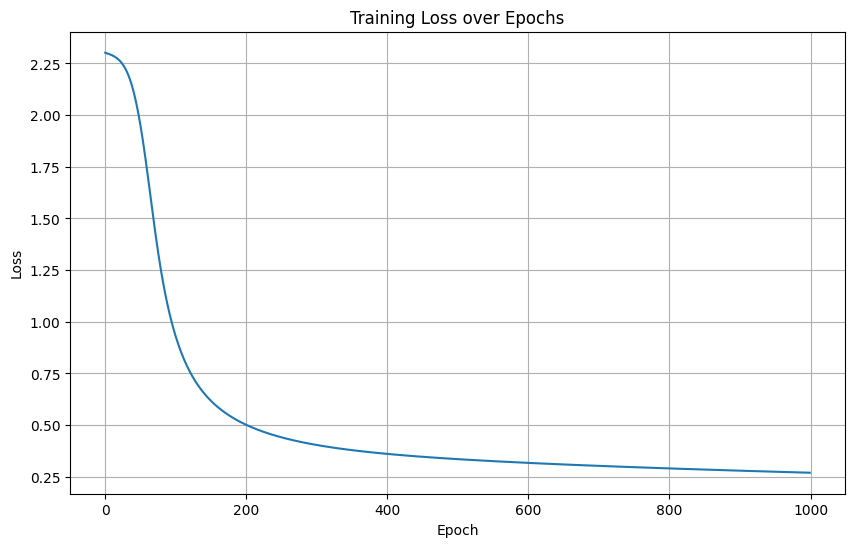

In [12]:
import matplotlib.pyplot as plt

# Note: This cell will not be fully executable until the training in cell 0f5667e9 is complete
# and the 'training_losses' list is populated.

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(training_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()